In [444]:
!pip install numpy_financial

In [445]:
import numpy as np
import pandas as pd
from scipy.optimize import newton
from scipy.optimize import fsolve
import numpy_financial as npf
from scipy.optimize import root
import matplotlib.pyplot as plt


In [446]:
# Read the Excel file
selected_bonds = pd.read_excel("/content/bonds.xlsx", parse_dates=['Maturity Date'],
    date_parser=lambda x: pd.to_datetime(x, format='%m/%d/%Y'))

# Define the 'today' list
today = [8, 9, 10, 11, 12, 15, 16, 17, 18, 19]

In [447]:
# Add the number of months from now to bonds' maturity for future convenience.
months_list = []
for i in range(len(selected_bonds)):
    colname_months = "Months"
    months_list.append((selected_bonds.iloc[i]['Maturity Date'].to_period('M') - pd.to_datetime('2024-01-15').to_period('M')).n)
selected_bonds[colname_months] = months_list

In [448]:
selected_bonds

,ISIN,Coupon,Issue Date,Maturity Date,Price1,Price2,Price3,Price4,Price5,Price6,Price7,Price8,Price9,Price10,Months
0,CA135087J546,0.0225,10/5/2018,2024-03-01,99.630,99.640,99.650,99.661,99.670,99.687,99.680,99.683,99.708,99.720,2
1,CA135087J967,0.0150,4/5/2019,2024-09-01,97.960,97.980,97.985,97.982,98.021,98.054,97.974,97.975,97.999,98.007,8
2,CA135087K528,0.0125,10/11/2019,2025-03-01,96.460,96.482,96.552,96.576,96.661,96.715,96.540,96.448,96.495,96.460,14
3,CA135087K940,0.0050,4/3/2020,2025-09-01,94.340,94.370,94.380,94.430,94.490,94.490,94.420,94.250,94.240,94.220,20
4,CA135087L518,0.0025,10/9/2020,2026-03-01,92.862,92.860,92.844,92.856,93.023,93.008,92.796,92.570,92.546,92.545,26
5,CA135087L930,0.0100,4/16/2021,2026-09-01,93.460,93.440,93.550,93.530,93.600,93.570,93.400,93.120,93.080,93.070,32
6,CA135087M847,0.0125,10/15/2021,2027-03-01,93.282,93.301,93.245,93.186,93.467,93.493,93.141,92.856,92.753,92.764,38
7,CA135087N837,0.0275,5/13/2022,2027-09-01,97.580,97.591,97.603,97.520,97.740,97.772,97.441,97.092,96.956,96.947,44
8,CA135087P576,0.0350,10/21/2022,2028-03-01,100.500,100.480,100.439,100.328,100.637,100.673,100.220,99.834,99.662,99.623,50
9,CA135087Q491,0.0325,4/21/2023,2028-09-01,99.740,99.720,99.720,99.550,99.880,99.910,99.440,98.990,98.810,98.770,56


In [449]:
# Compute the dirty price for each day. Notice that I assume that there are 360 days in each year, 30 days in each month.
# Since all my bonds have a maturity in either March or September, it has been four months (120 days) plus the current day since the last coupon payment.
for t in range(1, 11):
    colname_dirty_price = "DirtyPrice" + str(t)
    selected_bonds[colname_dirty_price] = (120+today[t-1]) / 360 * selected_bonds["Coupon"] * 100 + selected_bonds["Price" + str(t)]

In [450]:
def npv(rate, cash_flows, times):
    return sum(cf / (1 + rate)**time for cf, time in zip(cash_flows, times))

def irr(cash_flows, times):
    result = root(lambda r: npv(r, cash_flows, times), 0.0)
    return result.x[0] if result.success else None

In [451]:
# Loop through each of the first ten days
for day in range(1, 11):
    day_YTM = []

    # Iterate through each bond in the selected_bonds dataset
    for bond_index in range(len(selected_bonds)):
        num_periods = (selected_bonds.iloc[bond_index]['Months'] - 2) / 6 + 1
        cash_flows = [-selected_bonds.iloc[bond_index]["DirtyPrice" + str(day)]]
        payment_times = [0]

        # Generate cash flows for each payment period, excluding the last
        for period in range(1, int(num_periods)):
            cash_flows.append(selected_bonds.iloc[bond_index]['Coupon'] * 50)  # Semi-annual coupon payment
            payment_times.append((period - 1) * 0.5 + (60 - (today[day-1])) / 360)

        # Add the final cash flow
        cash_flows.append(selected_bonds.iloc[bond_index]['Coupon'] * 50 + 100)
        payment_times.append((num_periods - 1) * 0.5 + (60 - (today[day-1])) / 360)

        # Compute the YTM for the bond taking into account the timing of cash flows
        bond_YTM = irr(cash_flows, payment_times)
        day_YTM.append(bond_YTM)

    # Store the day's YTM values in the corresponding column of selected_bonds
    selected_bonds["YTM" + str(day)] = day_YTM



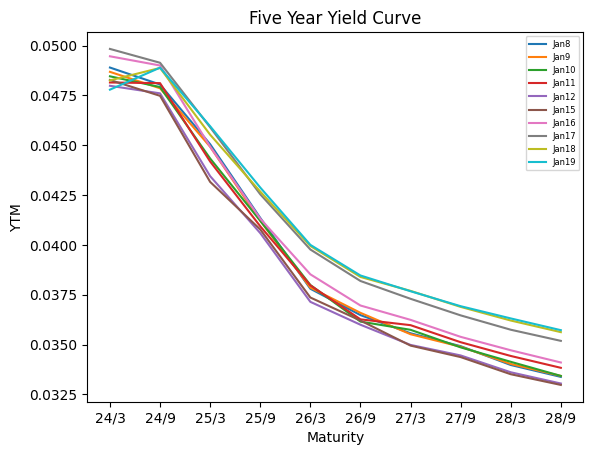

In [452]:
plt.xlabel('Maturity')
plt.ylabel('YTM')
plt.title('Five Year Yield Curve')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],labels = ['24/3','24/9','25/3','25/9', '26/3', '26/9', '27/3', '27/9', '28/3', '28/9','29/3'])
for i in range(1,11):
    plt.plot(selected_bonds['YTM'+str(i)], label = "Jan"+str(today[i-1]))
plt.legend(loc=1, prop={'size': 6})
plt.show()

In [453]:
# t=1
# while t<=10:
#   spot_rates = np.zeros(11)
#   colname_r = "r" + str(t)

#   for i in range(0,11):
#     price = selected_bonds['Price'+str(t)][i]
#     maturity = selected_bonds['Months'][i]
#     coupon_rate = selected_bonds['Coupon'][i]*100

#     cash_flows = np.array([coupon_rate] * int((maturity - 2)/6) + [100 + coupon_rate])
#     time_periods = np.arange(6, maturity+6, 6)

#     if i == 0:
#         discounted_cash_flows = cash_flows / (1 + spot_rates[i])**time_periods
#     else:
#         discounted_cash_flows = [cf / (1 + spot_rates[j])**time_periods[j] for j, cf in enumerate(cash_flows)]
#         discounted_cash_flows = np.sum(discounted_cash_flows)

#     residual = price - discounted_cash_flows
#     if residual <= 0:
#         # Handle cases where residual is too low
#         print(f"Warning: Residual for bond with maturity {maturity} is too low. Adjusting spot rate calculation.")
#         spot_rate = spot_rates[i-1]  # Use previous spot rate as an approximation
#     else:
#         spot_rate = ((100 / residual)**(1 / (maturity/12))) - 1
#     # print(discounted_cash_flows)
#     spot_rates[i] = spot_rate

#   selected_bonds[colname_r] = spot_rates
#   t = t + 1

In [454]:
# Loop through each day up to day 10
for day_count in range(1,11):

  # Generate the column name for the spot rate
  spot_rate_col = "r" + str(day_count)

  # Calculate the initial spot rate for the first bond
  initial_spot_rate = -np.log(selected_bonds["DirtyPrice" + str(day_count)][0] / (50 * selected_bonds['Coupon'][0] + 100)) / ((60 - (today[day_count-1] - 1)) / 360)
  spot_rates = [initial_spot_rate]

  bond_index = 1
  # Calculate spot rates for remaining bonds
  while bond_index <= 9:
      # Calculate term for summing cash flows
      cash_flow_sum = 50 * selected_bonds['Coupon'][bond_index] * np.exp(-initial_spot_rate * ((60 - (today[day_count-1] - 1)) / 360))
      cash_flow_index = 2
      while cash_flow_index <= bond_index:
          cash_flow_sum += 50 * selected_bonds['Coupon'][bond_index] * np.exp(-((cash_flow_index-1)/2 + ((60 - (today[day_count-1] - 1)) / 360)) * spot_rates[cash_flow_index-1])
          cash_flow_index += 1
      spot_rate_for_bond = -np.log((selected_bonds["DirtyPrice" + str(day_count)][bond_index] - cash_flow_sum) / (50 * selected_bonds['Coupon'][bond_index] + 100)) / ((bond_index)/2 + ((60 - (today[day_count-1] - 1)) / 360))
      spot_rates.append(spot_rate_for_bond)
      bond_index += 1

  selected_bonds[spot_rate_col] = spot_rates

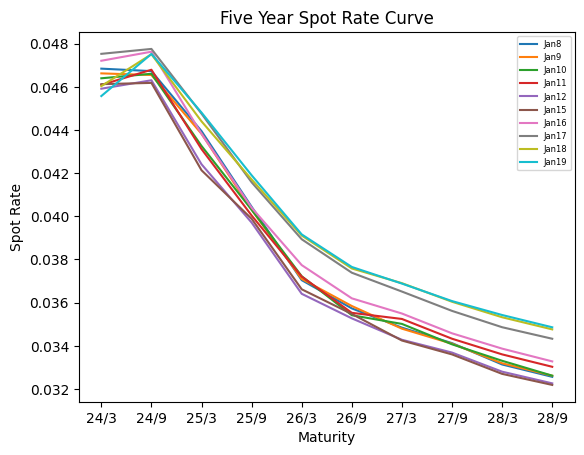

In [455]:
plt.xlabel('Maturity')
plt.ylabel('Spot Rate')
plt.title('Five Year Spot Rate Curve')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],labels = ['24/3','24/9','25/3','25/9', '26/3', '26/9', '27/3', '27/9', '28/3', '28/9','29/3'])
for i in range(1,11):
    plt.plot(selected_bonds['r'+str(i)], label = "Jan"+str(today[i-1]))
plt.legend(loc=1, prop={'size': 6})
plt.show()

In [456]:
# Defind forward rate calculation using the formula in assignment hints.
def calculate_forward_rate(r_t, r_tn, t, tn):
    return ((1 + r_tn)**(2 * tn) / (1 + r_t)**(2 * t))**(1 / (2 * (tn - t))) - 1

# Calculate forward rates for each day using the spot rates from r1 to r10
for i in range(1, 11):
    selected_bonds[f'f{i}'] = selected_bonds.apply(
        lambda row: calculate_forward_rate(row[f'r{i}'], row[f'r{i}'], 0, int(row['Months']/12+1)),
        axis=1
    )

forward_rates = []
# Calculate the forward rates for each period from 1-1yr to 1-4yr
for i in range(1, 11):
    forward_rates_for_day = []
    for j in range(1, 5):
        # Calculate the forward rate from 1yr to j years
        forward_rate = calculate_forward_rate(
            selected_bonds.iloc[0][f'r{i}'],
            selected_bonds.iloc[j+2][f'r{i}'],
            t=1,
            tn=1 + j
        )
        forward_rates_for_day.append(forward_rate)
    forward_rates.append(forward_rates_for_day)

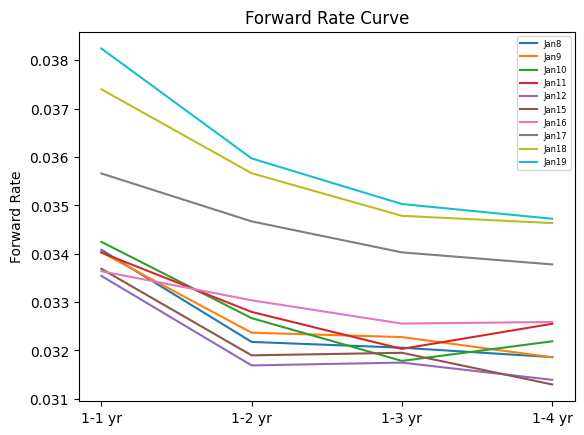

In [457]:
plt.ylabel('Forward Rate')
plt.title('Forward Rate Curve')
plt.xticks(ticks = [0, 1, 2, 3],labels = ['1-1 yr','1-2 yr','1-3 yr','1-4 yr'])
for i in range(1,11):
    plt.plot(forward_rates[i-1], label = "Jan"+str(today[i-1]))
plt.legend(loc=1, prop={'size': 6})
plt.show()

In [458]:
selected_bonds.to_csv("result1.csv")

In [459]:
# Time Series for yield.
i = 1
X_ytm = []
while i <= 10:
    yield_i_j_1 = selected_bonds.iloc[i-1, 26:35].values.astype(float)
    yield_i_j = selected_bonds.iloc[i-1, 25:34].values.astype(float)
    X_ytm_i = np.log(yield_i_j_1/yield_i_j)
    X_ytm.append(X_ytm_i)
    i = i + 2

M_ytm = np.cov(X_ytm)
print(M_ytm)
eigen_space_ytm = np.linalg.eig(M_ytm)
print(eigen_space_ytm[0])
print(eigen_space_ytm[1])

[[2.31262293e-04 1.84077135e-04 1.32886606e-04 1.16630220e-04
  9.89984489e-05]
 [1.84077135e-04 3.37593367e-04 2.56319547e-04 2.78944868e-04
  2.70840652e-04]
 [1.32886606e-04 2.56319547e-04 2.69540988e-04 2.92676043e-04
  2.72531487e-04]
 [1.16630220e-04 2.78944868e-04 2.92676043e-04 3.44165017e-04
  3.22377143e-04]
 [9.89984489e-05 2.70840652e-04 2.72531487e-04 3.22377143e-04
  3.06816589e-04]]
[1.23407747e-03 1.96853283e-04 4.71215139e-05 1.05905660e-05
 7.35420615e-07]
[[-0.25630107 -0.8506175  -0.3926909   0.21468323  0.10229658]
 [-0.48646715 -0.27138743  0.81008846 -0.10190112 -0.15189281]
 [-0.45500257  0.09185144 -0.33547005 -0.81805277  0.05277768]
 [-0.50974708  0.30201823 -0.27750403  0.38940692 -0.64830292]
 [-0.48040614  0.32116511  0.00137858  0.35025589  0.73714437]]


In [460]:
# Time Series for forward rate.
i = 1

forward_rates_array = np.array(forward_rates).T
X_forward = np.zeros((4, 9))
for i in range(len(forward_rates_array)):
    for j in range(len(forward_rates_array[i])-1):
        X_forward[i][j] = math.log(forward_rates_array[i][j]/forward_rates_array[i][j+1])

M_forward = np.cov(X_forward)
print(M_forward)
eigen_space_forward = np.linalg.eig(M_forward)
print(eigen_space_forward[0])
print(eigen_space_forward[1])

[[0.0006259  0.00042695 0.00032707 0.00033462]
 [0.00042695 0.00055049 0.00033101 0.00052195]
 [0.00032707 0.00033101 0.00030358 0.00028675]
 [0.00033462 0.00052195 0.00028675 0.00053612]]
[1.64978554e-03 2.77621935e-04 7.95791472e-05 9.10125241e-06]
[[ 0.52379146  0.76838795 -0.3395036   0.14127906]
 [ 0.56242948 -0.2845239  -0.09677505 -0.77029463]
 [ 0.37583198  0.12547598  0.91109871  0.11360127]
 [ 0.51775082 -0.55935846 -0.21276993  0.61137644]]
